### Randomizing an adjacency

Algorithms to randomize an adjacency matrix of a binary undirected network preserving each node degree.

#### For weighed networks, you need to preserve strengths not just degrees, so:
- Take a random pair of links ij and kl 
- Consider the strengths w_ij, w_kl as well as w_il and w_kj 
- Set w_il to a new value equal to old w_ij and w_ij to a new value equal to old w_il 
- Set w_kj to a new value equal to old w_kl and w_kl to a new value equal to old w_kj 
- Do the same for the pair ji and lk, since the coherence networks must be symmetric 


In [1]:
%matplotlib inline
import ctypes
import numpy             as np
import numba             as nb
import matplotlib.pyplot as plt
from   tqdm              import tqdm

In [2]:
_ra = ctypes.CDLL('./libwadj.so')

In [3]:
_ra.randomize_adjacency_wei.argtypes = (ctypes.c_int, ctypes.c_int, 
                                        ctypes.POINTER(ctypes.POINTER(ctypes.c_float)), 
                                        ctypes.POINTER(ctypes.c_int))
_ra.randomize_adjacency_wei.restype  = ctypes.POINTER(ctypes.POINTER(ctypes.c_float))

### Defining wrapper for C function in python

In [46]:
def randomize_adjacency_wei(A, n_rewires, seed):
    global _ra
    A_copy = np.array(A, dtype=np.float32).copy()
    # Number of nodes
    n_nodes = A_copy.shape[0]
    # Getting edges
    i,j   = np.tril_indices_from(A_copy, k=-1)
    w     = A_copy[i,j]
    edges = np.array([j,i]).T
    i,j   = edges[w.astype(bool),:].T
    # Number of edges
    n_edges = len(i)
    
    #
    UI8Ptr    = ctypes.POINTER(ctypes.c_float)
    UI8PtrPtr = ctypes.POINTER(UI8Ptr)

    ct_arr    = np.ctypeslib.as_ctypes(A_copy)
    UI8PtrArr = UI8Ptr * ct_arr._length_
    ct_ptr    = ctypes.cast(UI8PtrArr(*(ctypes.cast(row, UI8Ptr) for row in ct_arr)), UI8PtrPtr)

    
    array_type  = (ctypes.c_int * n_edges)
    
    # Call function
    Arn = _ra.randomize_adjacency_wei(ctypes.c_int(n_rewires), ctypes.c_int(n_nodes), \
                                  ct_ptr, ctypes.c_int(seed))
    
    Arn_py = np.array([[Arn[i][j] for j in range(n_nodes)] for i in range(n_nodes)], dtype=Arn._type_._type_._type_)
    return Arn_py

### Python implementation

In [47]:
#@nb.jit(nopython=True)
def _randomize_adjacency_wei(A, n_swaps, seed):
    
    np.random.seed(seed)
    
    # Number of nodes
    n_nodes = A.shape[0]
    # Copy the adj. matrix
    Arnd    = A.copy()
    
    # Choose edges that will be swaped
    edges = np.random.choice(n_nodes, size=(4, n_swaps), replace=True).T
    
    #itr = range(n_swaps)
    #for it in tqdm(itr) if verbose else itr:
    it = 0
    for it in range(n_swaps):
        i,j,k,l = edges[it,:]
        if len(np.unique([i,j,k,l]))<4:
            continue
        else:
            # Old values of weigths
            w_ij,w_il,w_kj,w_kl=Arnd[i,j],Arnd[i,l],Arnd[k,j],Arnd[k,l]
            # Swaping edges
            Arnd[i,j]=Arnd[j,i]=w_il
            Arnd[k,l]=Arnd[l,k]=w_kj
            Arnd[i,l]=Arnd[l,i]=w_ij
            Arnd[k,j]=Arnd[j,k]=w_kl
    return Arnd

#### Load an adjacency matrix

In [48]:
A = np.loadtxt('adj.txt',delimiter=' ', dtype=int)

In [49]:
A = A * np.random.randint(0,10,A.shape)
A = (A+A.T)/2
np.fill_diagonal(A,1)

#### C

In [57]:
Arn    = randomize_adjacency_wei(A, 1000, 0)

#### Python

In [58]:
Arn_py = _randomize_adjacency_wei(A, 1000, 0)

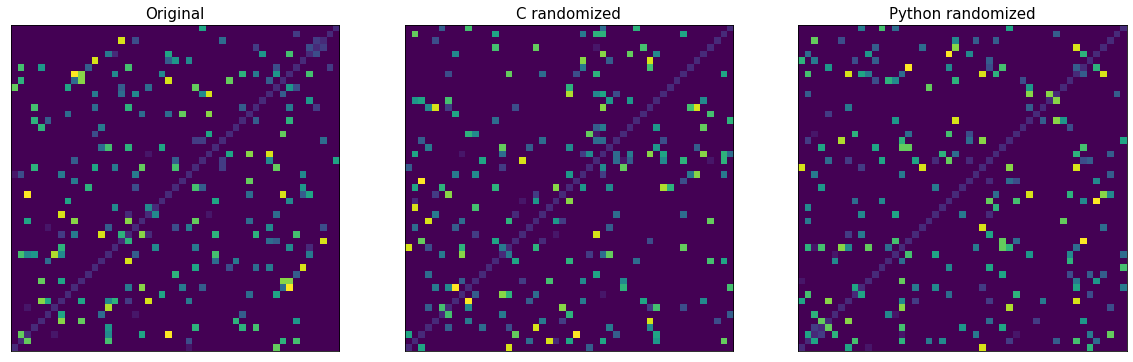

In [86]:
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.imshow(A,aspect='auto',cmap='viridis', origin = 'lower')
plt.title('Original', fontsize=15)
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,2)
plt.imshow(Arn,aspect='auto',cmap='viridis', origin = 'lower')
plt.title('C randomized', fontsize=15)
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,3)
plt.imshow(Arn_py,aspect='auto',cmap='viridis', origin = 'lower')
plt.title('Python randomized', fontsize=15)
plt.xticks([])
plt.yticks([]);

In [87]:
d1=A.sum(-1)
d2=Arn_py.sum(-1)
d3=Arn_py.sum(-1)
print('Average strength of the network:')
print('---------------------------------------')
print(f'Original          = {d1.mean()}')
print(f'C randomized      = {d2.mean()}')
print(f'Python randomized = {d3.mean()}')

Average strength of the network:
---------------------------------------
Original          = 20.367346938775512
C randomized      = 20.367346938775512
Python randomized = 20.367346938775512


#### Test if average network strength is maintained for different seeds

#### Check if the degrees were preserved

In [88]:
d_o = A.sum(axis = 1)
d_c = Arn.sum(axis = 1)
d_p = Arn_py.sum(axis = 1)

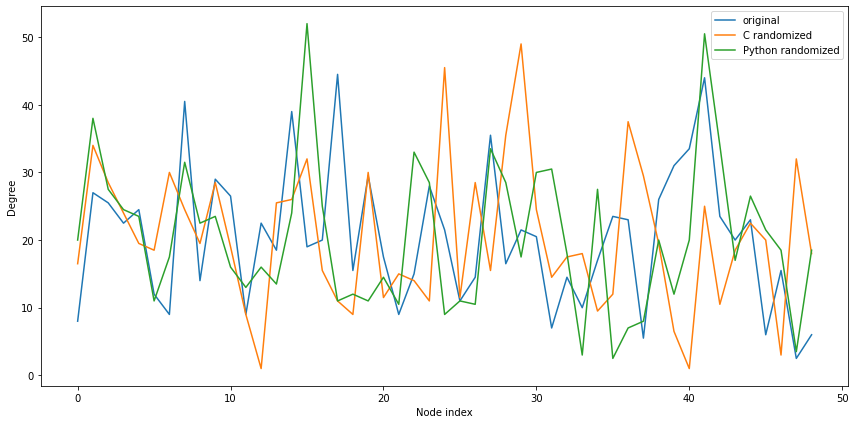

In [92]:
plt.figure(figsize=(12,6))
plt.plot(d_o, label = 'original')
plt.plot(d_c, label = 'C randomized')
plt.plot(d_p, label = 'Python randomized')
plt.xlabel('Node index')
plt.ylabel('Degree')
plt.legend()
plt.tight_layout()

### Comparing perfomance between Python, C and igraph

In [77]:
n_rewires = np.arange(10, 111 * np.log(1/1e-8), 100, dtype=int)
ex_t      = np.zeros([2,2,len(n_rewires)])

In [91]:
plt.figure(figsize=(12,6))
for i in range(n_rewires.shape[0]):
    t1 = %timeit -o randomize_adjacency_wei(A, n_rewires[i], 0)
    ex_t[0,0,i]=t1.average
    ex_t[0,1,i]=t1.stdev
    t2 = %timeit -o _randomize_adjacency_wei(A, n_rewires[i], 0)
    ex_t[1,0,i]=t2.average
    ex_t[1,1,i]=t2.stdev

521 µs ± 5.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
118 µs ± 4.1 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
568 µs ± 18.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.02 ms ± 17.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
556 µs ± 18.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.91 ms ± 32.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
540 µs ± 6.53 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
2.81 ms ± 33.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
546 µs ± 6.78 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
3.73 ms ± 89.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
565 µs ± 7.65 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
4.7 ms ± 93.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
572 µs ± 6.88 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
5.54 ms ± 68.4 µs per loop (mean ± std. dev. of 7 runs, 100 loop

<Figure size 864x432 with 0 Axes>

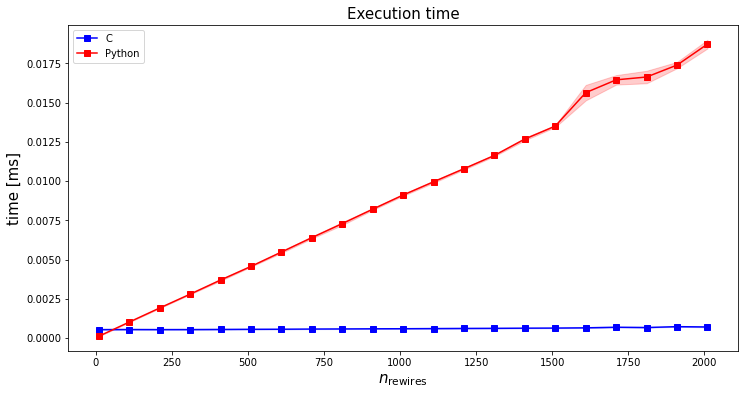

In [83]:
plt.figure(figsize=(12,6))
plt.plot(n_rewires, ex_t[0,0], 's-b', label = 'C')
plt.fill_between(n_rewires, ex_t[0,0]-ex_t[0,1], ex_t[0,0]+ex_t[0,1], color='b', alpha = .2)
#
plt.plot(n_rewires, ex_t[1,0], 'r-s', label = 'Python')
plt.fill_between(n_rewires, ex_t[1,0]-ex_t[1,1], ex_t[1,0]+ex_t[1,1], color='r', alpha = .2)
plt.xlabel(r'$n_{\rm rewires}$', fontsize=15)
plt.ylabel('time [ms]', fontsize=15)
plt.title('Execution time', fontsize=15)
plt.legend()

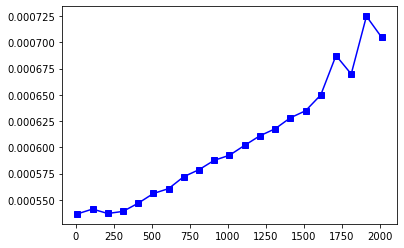

In [84]:
plt.plot(n_rewires, ex_t[0,0], 's-b', label = 'C')

In [85]:
n_rewires

array([  10,  110,  210,  310,  410,  510,  610,  710,  810,  910, 1010,
       1110, 1210, 1310, 1410, 1510, 1610, 1710, 1810, 1910, 2010])